In [1]:
import os
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from torchvision.transforms import Compose, Normalize, ToTensor
from matplotlib import pyplot as plt

In [2]:
path = 'MoRF'

In [ ]:
directory_imgs = path+"/imgs/"
directory_cams = path+"/cams/"
os.makedirs(directory_cams, exist_ok=True)
width, height = 224, 224

# Initialize model
model = models.resnet50(pretrained=True)
model.eval()
target_layers = [model.layer4]

# Generate CAMs
for filename in sorted(os.listdir(directory_imgs)):
    if filename.endswith(".JPEG"):
        img_path = os.path.join(directory_imgs, filename)
        print(img_path)
        img = cv2.imread(img_path, 1)[:, :, ::-1]
        resized_image = cv2.resize(img, (width, height))
        resized_image = np.float32(resized_image) / 255
        input_tensor = preprocess_image(resized_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor)[0]
            cam_image = np.uint8(grayscale_cam * 255)
            cam_path = os.path.join(directory_cams, f"cam_{filename}")
            print(cam_path)
            cv2.imwrite(cam_path, cam_image)


In [ ]:
def show_image_and_cam(img_path, cam_path):
    original_img = cv2.imread(img_path)[:, :, ::-1]
    cam_img = cv2.imread(cam_path, cv2.IMREAD_GRAYSCALE)
    cam_img_resized = cv2.resize(cam_img, (original_img.shape[1], original_img.shape[0]))
    heatmap = cv2.applyColorMap(cam_img_resized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam_img_resized, cmap="gray")
    plt.title("CAM (Grayscale)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay (Image + CAM)")
    plt.axis("off")
    plt.show()


def preprocess_image(img_path):
    preprocess = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(img_path).convert("RGB")
    image = image.resize((224, 224))
    return preprocess(image).unsqueeze(0)


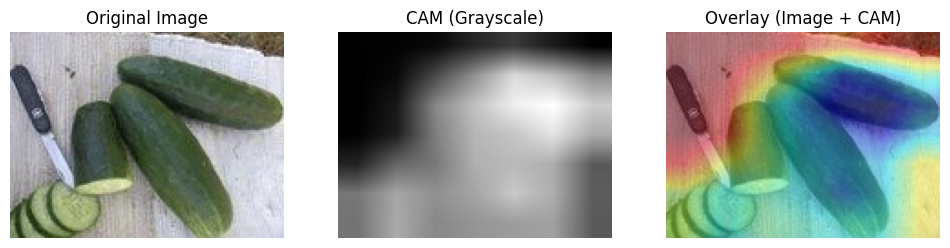

943: 'cucumber, cuke',: 0.9757
939: 'zucchini, courgette',: 0.0243
940: 'spaghetti squash',: 0.0000
998: 'ear, spike, capitulum',: 0.0000
941: 'acorn squash',: 0.0000
943: 'cucumber, cuke',: 0.9757
939: 'zucchini, courgette',: 0.0243
940: 'spaghetti squash',: 0.0000
998: 'ear, spike, capitulum',: 0.0000
941: 'acorn squash',: 0.0000


In [10]:
from PIL import Image
image = 'n07718472_1428.JPEG'
cam = 'cam_'+image

# Example usage
imgs_dir = path+"/imgs/"
cams_dir = path+"/cams/"
example_image = os.path.join(imgs_dir, image)
example_cam = os.path.join(cams_dir, cam)

show_image_and_cam(example_image, example_cam)

img_path = imgs_dir+image
input_tensor = preprocess_image(img_path)

output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the top-5 predictions
top5_prob, top5_classes = torch.topk(probabilities, 5)

# Load ImageNet class labels
imagenet_classes = {idx: entry.strip() for idx, entry in enumerate(open(path+"/imagenet_classes.txt"))}

# Print top-5 predictions
for i in range(5):
    print(f"{imagenet_classes[top5_classes[i].item()]}: {top5_prob[i].item():.4f}")
